In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
dim = (128, 128, 3)
target_size = dim[:2]
seed = 42
batch_size = 64 

Import libraries 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
import os
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, MaxPooling2D
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.models import load_model

import skimage
from skimage import exposure

load dataset, apply preprocessing, and split it into train, test, validation

In [5]:
shutil.copyfile('drive/MyDrive/LISA-GTSRBv2.zip', 'LISA-GTSRBv2.zip')

'LISA-GTSRBv2.zip'

In [6]:
shutil.unpack_archive('LISA-GTSRBv2.zip', 'LISA-GTSRBv2')

In [7]:
# Generating images for the dataset
datagen = ImageDataGenerator(rescale=None)

# Creating the Training set
dataset = datagen.flow_from_directory('LISA-GTSRBv2/Train',
                                      target_size = target_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      color_mode = 'rgb',
                                      shuffle = True,
                                      seed = seed)

Found 103454 images belonging to 46 classes.


In [8]:
encoding = {v:k for k, v in dataset.class_indices.items()}

In [9]:
images, labels = dataset.next()

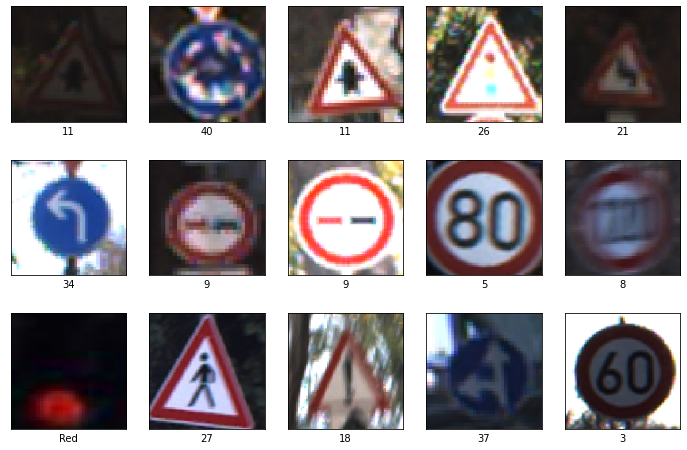

In [10]:
plt.figure(figsize=(12, 8))
font = {'size': 10}
plt.rc('font', **font)

j = 1
for i in list(range(15)):
    plt.subplot(3, 5, j)
    plt.xticks([])
    plt.yticks([])
    
    idx = labels[i].argmax()
    plt.xlabel(encoding[idx])
    plt.imshow(images[i]/255)

    j += 1
plt.show()

In [11]:
# Generating images for the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

# Creating the Training set
train_set = train_datagen.flow_from_directory('LISA-GTSRBv2/Train',
                                      target_size = target_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset='training',
                                      color_mode = 'rgb',
                                      interpolation = 'bicubic',
                                      shuffle = True,
                                      seed = seed)

Found 82800 images belonging to 46 classes.


In [12]:
# Creating the Validation set
val_set = train_datagen.flow_from_directory('LISA-GTSRBv2/Train',
                                      target_size = target_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset='validation',
                                      color_mode = 'rgb',
                                      interpolation = 'bicubic',
                                      shuffle = True,
                                      seed = seed)

Found 20654 images belonging to 46 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the Testing set
test_set = test_datagen.flow_from_directory('LISA-GTSRBv2/Test',
                                            target_size = target_size,
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            color_mode = 'rgb',
                                            interpolation = 'bicubic',
                                            shuffle = False)

Found 34454 images belonging to 46 classes.


In [14]:
print('Image Size (Pixels):', target_size)
print('Training set:', train_set.n, 'images')
print('Validation set:', val_set.n, 'images')
print('Test set:', test_set.n, 'images')

Image Size (Pixels): (128, 128)
Training set: 82800 images
Validation set: 20654 images
Test set: 34454 images


**function for evaluation the model**

In [15]:
from sklearn.metrics import balanced_accuracy_score

# This function plots the confusion matrix and prints accuracy, precision, recall and F1 score
def report(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  labels = list(train_set.class_indices.keys())
  cm = pd.DataFrame(cm, columns=labels, index=labels)

  acc = np.round(accuracy_score(y_test, y_pred)*100, 2)
  b_acc = np.round(balanced_accuracy_score(y_test, y_pred)*100, 2)
  p = np.round(precision_score(y_test, y_pred, average = 'macro')*100, 2)
  r = np.round(recall_score(y_test, y_pred, average = 'macro')*100, 2)
  f1 = np.round(f1_score(y_test, y_pred, average = 'macro')*100, 2)

  data = [acc, b_acc, p, r, f1]

  idx = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall (Sensitivity)', 'F1']
  results = pd.DataFrame(index=idx, data = data, columns=['Value'])
  results.index.name = 'Metric'
  display(results)

  plt.figure(figsize=(20, 20))
  sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt = 'd', annot_kws={"size": 10}).set_title('Confusion Matrix')
  plt.show()

In [16]:
# Visualizing Training History
def draw(train, val, title):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(1, epochs+1), 
          train, 
          color = 'green',
          label = "Training")
  
  plt.plot(np.arange(1, epochs+1), 
          val, 
          color = 'red',
          label = "Validation")
  
  plt.legend()
  plt.title(title)
  plt.show()


def visualizeTrainingHistory(history):
  # Plot accuracy
  draw(history.history['accuracy'], 
      history.history['val_accuracy'],
      "Training vs. Validation Accuracy")

  # Plot loss
  draw(history.history['loss'], 
      history.history['val_loss'],
      "Training vs. Validation Loss")

**First Model :    
adam optimizer is used, 2 dense layers, droupout 0.5 ,and training on 10 epochs**

In [ ]:
def basic(epochs=10, batch_size=32, dropout_rate=0.5, monitor='val_accuracy', mode='max', opt='adam',model_name='model'):
    

    model= Sequential()
    model.add(Conv2D(32,(3,3), input_shape=(128,128,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten()) 
    x = model.output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) 
    x = tf.keras.layers.Dense(128, activation='relu')(x) 

  # Output Layers
    predictions = tf.keras.layers.Dense(46, activation='softmax')(x)
  # Creating the model
    m = tf.keras.Model(model.input, predictions )
    m.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    checkpoint = ModelCheckpoint(filepath = 'SavedModels/'+model_name+'.h5', 
                               monitor=monitor, mode=mode, verbose=1,
                               save_best_only=True, save_weights_only=False)
    history = m.fit(train_set,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data = val_set,
                      callbacks=[checkpoint])
    return m, history
epochs = 10

In [ ]:
lr = 0.0001
adam = tf.keras.optimizers.Adam(lr)
sgd = tf.keras.optimizers.SGD()

In [ ]:
model_name='model'
m, history = basic(epochs=epochs, batch_size=batch_size, opt=adam,model_name=model_name)

Epoch 1/10
1294/1294 [==============================] - ETA: 0s - loss: 1.2009 - accuracy: 0.6862
Epoch 1: val_accuracy improved from -inf to 0.76571, saving model to SavedModels/model.h5
1294/1294 [==============================] - 112s 86ms/step - loss: 1.2009 - accuracy: 0.6862 - val_loss: 1.0161 - val_accuracy: 0.7657
Epoch 2/10
1294/1294 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9368
Epoch 2: val_accuracy improved from 0.76571 to 0.81156, saving model to SavedModels/model.h5
1294/1294 [==============================] - 111s 85ms/step - loss: 0.2372 - accuracy: 0.9368 - val_loss: 0.9140 - val_accuracy: 0.8116
Epoch 3/10
1294/1294 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9633
Epoch 3: val_accuracy improved from 0.81156 to 0.83287, saving model to SavedModels/model.h5
1294/1294 [==============================] - 112s 87ms/step - loss: 0.1367 - accuracy: 0.9633 - val_loss: 0.7989 - val_accuracy: 0.8329
Epoch 4/10
1294/1294 [

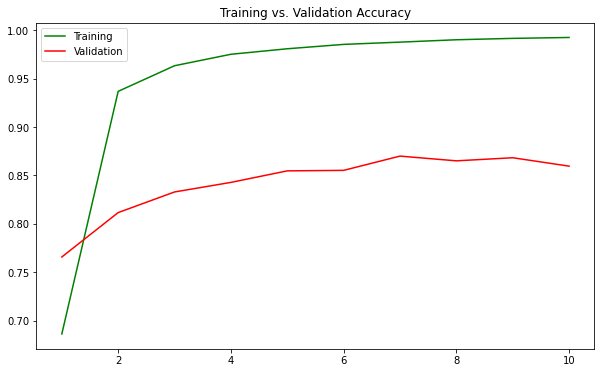

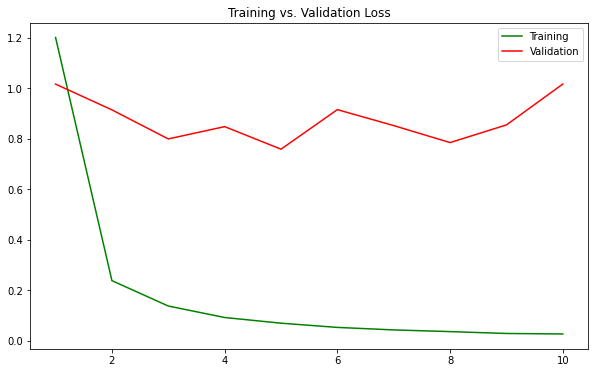

In [ ]:
visualizeTrainingHistory(history) 

In [ ]:
m.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_9 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 activation_10 (Activation)  (None, 61, 61, 32)        0   

,Value
Metric,
Accuracy,87.54
Balanced Accuracy,87.54
Precision,88.32
Recall (Sensitivity),87.54
F1,87.27


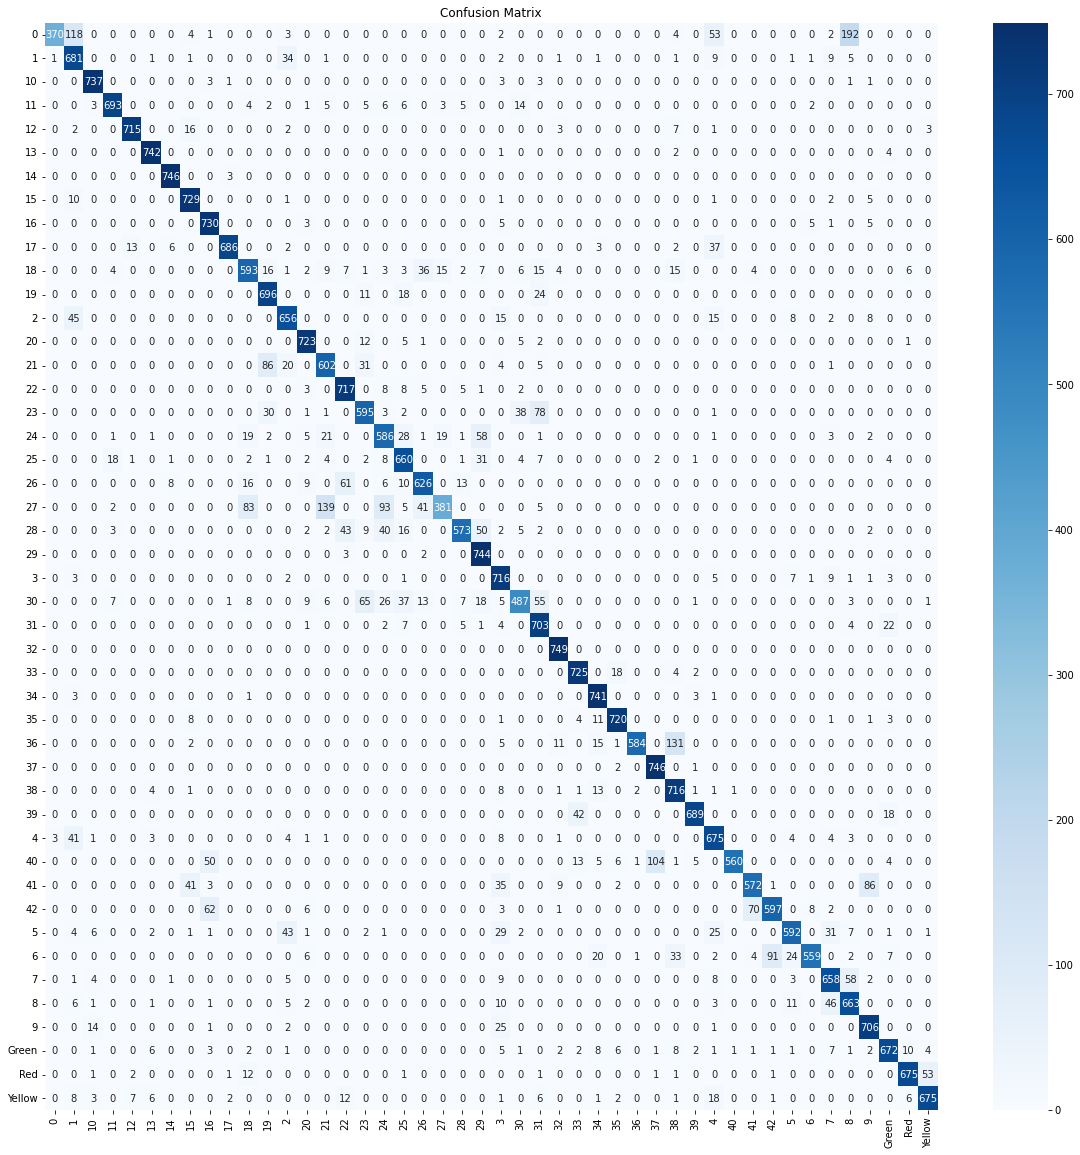

In [ ]:
# Loading the Model
model = load_model("SavedModels/"+model_name+".h5")

# Model Performance
y_test = test_set.labels
y_pred = model.predict(test_set).argmax(1)
report(y_test, y_pred)

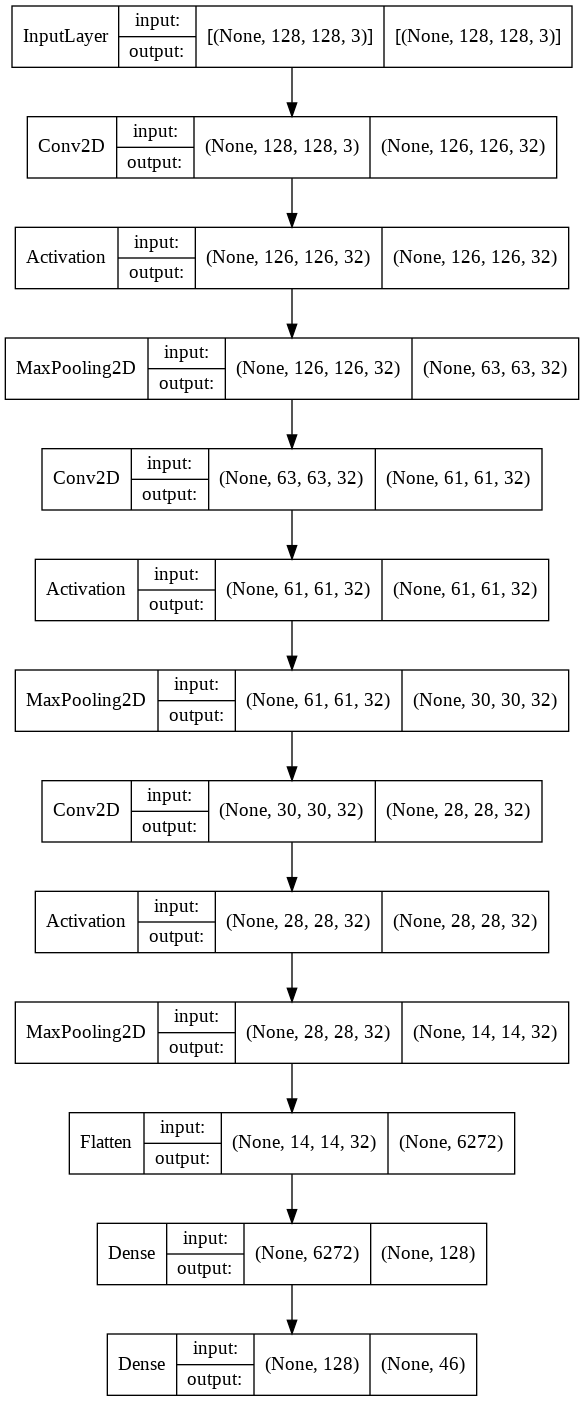

In [ ]:
# Plot the Model
plot_model(m, show_shapes=True, show_layer_names=False)

**Second Model:**                 

Adam optimizer is used, three dense layers, two dropout with 0.5, and training on 25 epochs





In [17]:
def basic(epochs=10, batch_size=32, dropout_rate=0.5, monitor='val_accuracy', mode='max', opt='adam',model_name='model'):

    model= Sequential()
    model.add(Conv2D(32,(3,3), input_shape=(128,128,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten()) 
    x = model.output
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x) 
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) 
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x) 

  # Output Layers
    predictions = tf.keras.layers.Dense(46, activation='softmax')(x)
  # Creating the model
    m = tf.keras.Model(model.input, predictions )
    m.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    checkpoint = ModelCheckpoint(filepath = 'SavedModels/'+model_name+'.h5', 
                               monitor=monitor, mode=mode, verbose=1,
                               save_best_only=True, save_weights_only=False)
    history = m.fit(train_set,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data = val_set,
                      callbacks=[checkpoint])
    return m, history
epochs = 25

In [18]:
model_name='model'
lr = 0.0001
adam = tf.keras.optimizers.Adam(lr)
m, history = basic(epochs=epochs, batch_size=batch_size, opt=adam,model_name=model_name)

Epoch 1/25
1294/1294 [==============================] - ETA: 0s - loss: 1.5952 - accuracy: 0.5514
Epoch 1: val_accuracy improved from -inf to 0.78440, saving model to SavedModels/model.h5
1294/1294 [==============================] - 122s 85ms/step - loss: 1.5952 - accuracy: 0.5514 - val_loss: 0.7747 - val_accuracy: 0.7844
Epoch 2/25
1294/1294 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.9150
Epoch 2: val_accuracy improved from 0.78440 to 0.85509, saving model to SavedModels/model.h5
1294/1294 [==============================] - 109s 84ms/step - loss: 0.2965 - accuracy: 0.9150 - val_loss: 0.5846 - val_accuracy: 0.8551
Epoch 3/25
1294/1294 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9567
Epoch 3: val_accuracy improved from 0.85509 to 0.87862, saving model to SavedModels/model.h5
1294/1294 [==============================] - 107s 82ms/step - loss: 0.1492 - accuracy: 0.9567 - val_loss: 0.5095 - val_accuracy: 0.8786
Epoch 4/25
1294/1294 [

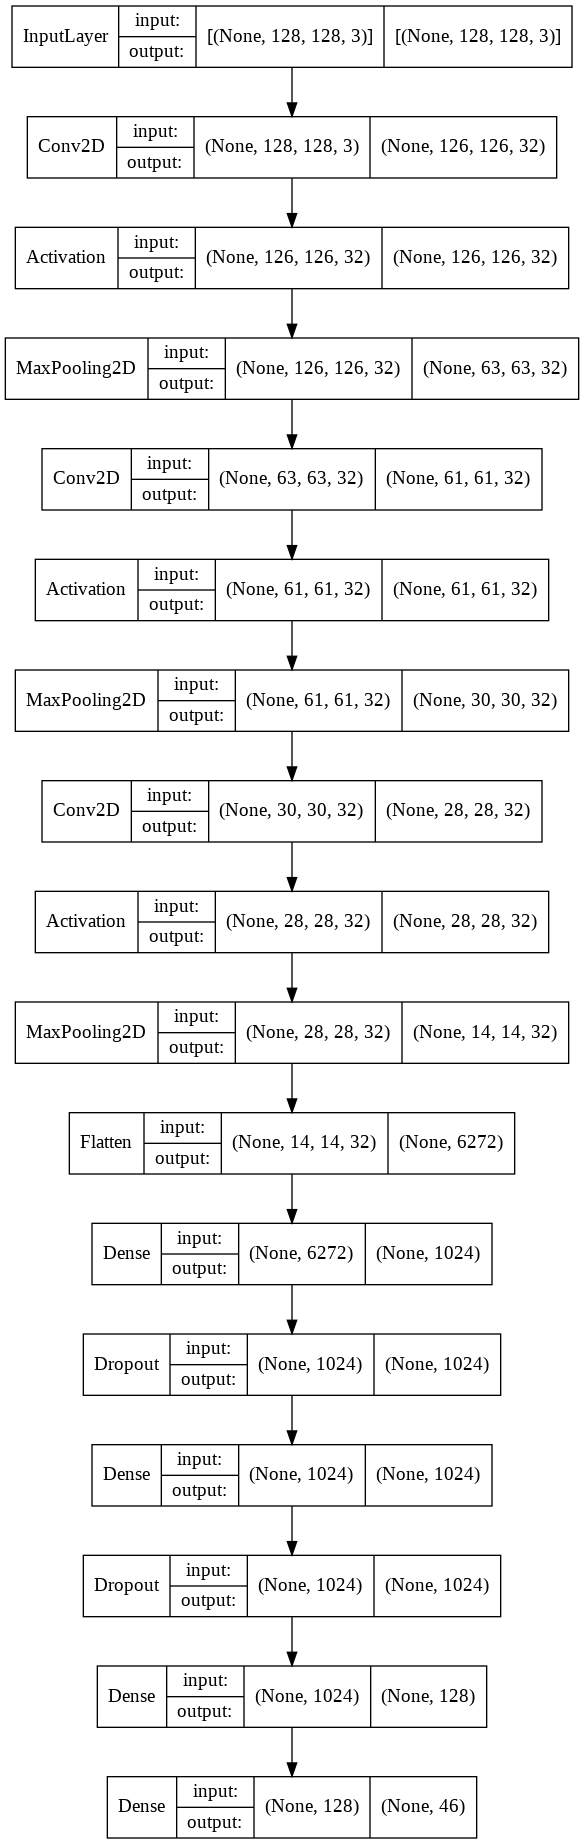

In [19]:
plot_model(m, show_shapes=True, show_layer_names=False)

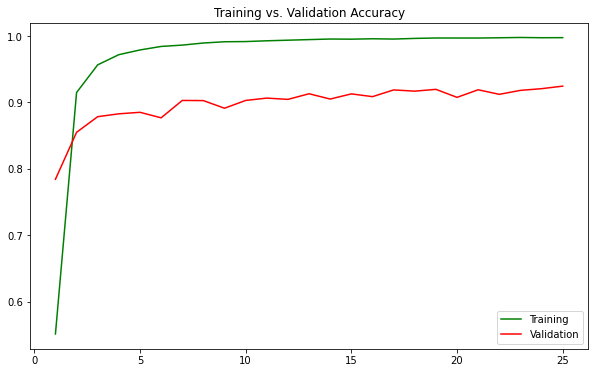

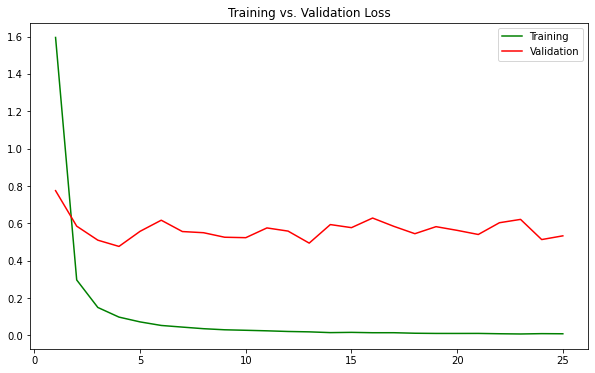

In [20]:
visualizeTrainingHistory(history)

,Value
Metric,
Accuracy,92.93
Balanced Accuracy,92.93
Precision,93.40
Recall (Sensitivity),92.93
F1,92.87


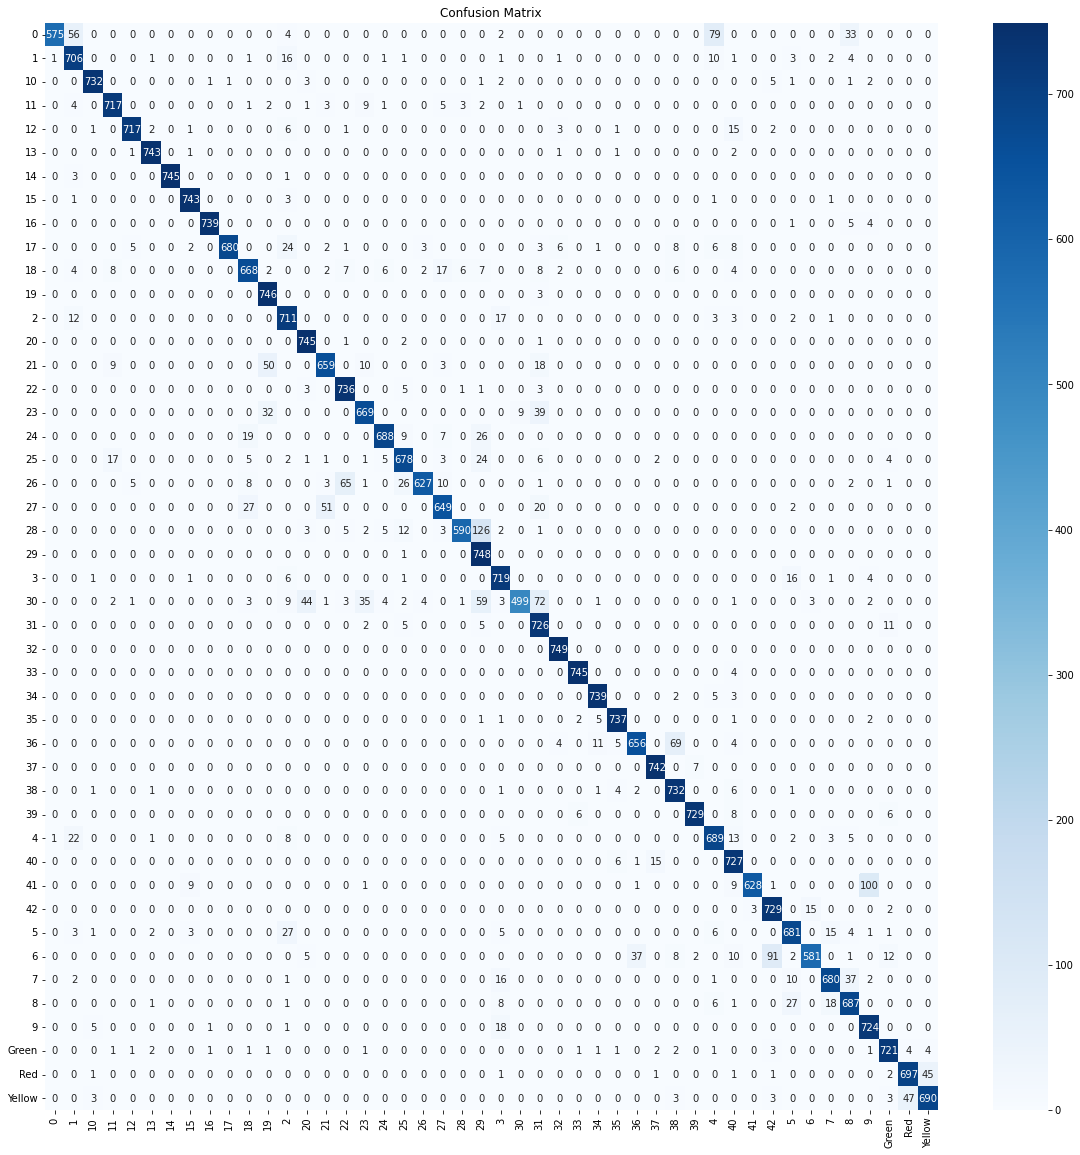

In [ ]:
# Loading the Model
model = load_model("SavedModels/"+model_name+".h5")

# Model Performance
y_test = test_set.labels
y_pred = model.predict(test_set).argmax(1)
report(y_test, y_pred)

**Third Model:**                      

Adam optimizer is used, two dense layers, one dropout, and training on 20 epochs.

batch normalization is used in the first layers.

In [ ]:
from tensorflow.keras.layers import BatchNormalization 

In [ ]:
def basic(epochs=10, batch_size=32, dropout_rate=0.5, monitor='val_accuracy', mode='max', opt='adam',model_name='model'):
    

    model= Sequential()
    model.add(Conv2D(32,(3,3), input_shape=(128,128,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32,(3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32,(3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32,(3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))   
    
    model.add(Conv2D(32,(3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))   

    model.add(Flatten()) 
    x = model.output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) 
    x = tf.keras.layers.Dense(128, activation='relu')(x) 

  # Output Layers
    predictions = tf.keras.layers.Dense(46, activation='softmax')(x)
  # Creating the model
    m = tf.keras.Model(model.input, predictions)
    m.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    checkpoint = ModelCheckpoint(filepath = 'SavedModels/'+model_name+'.h5', 
                               monitor=monitor, mode=mode, verbose=1,
                               save_best_only=True, save_weights_only=False)
    history = m.fit(train_set,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data = val_set,
                      callbacks=[checkpoint])
    return m, history

In [ ]:
model_name='model'
lr = 0.0001
epochs = 20
adam = tf.keras.optimizers.Adam()
m, history = basic(epochs=epochs, batch_size=batch_size, opt=adam,model_name=model_name)

Epoch 1/20
1294/1294 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.7427
Epoch 1: val_accuracy improved from -inf to 0.85194, saving model to SavedModels/model.h5
1294/1294 [==============================] - 124s 96ms/step - loss: 0.8426 - accuracy: 0.7427 - val_loss: 0.5458 - val_accuracy: 0.8519
Epoch 2/20
1294/1294 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9276
Epoch 2: val_accuracy improved from 0.85194 to 0.92413, saving model to SavedModels/model.h5
1294/1294 [==============================] - 118s 91ms/step - loss: 0.2244 - accuracy: 0.9276 - val_loss: 0.3900 - val_accuracy: 0.9241
Epoch 3/20
1294/1294 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9509
Epoch 3: val_accuracy did not improve from 0.92413
1294/1294 [==============================] - 119s 92ms/step - loss: 0.1559 - accuracy: 0.9509 - val_loss: 0.3104 - val_accuracy: 0.9174
Epoch 4/20
1294/1294 [==============================] - ETA: 0s 

,Value
Metric,
Accuracy,97.42
Balanced Accuracy,97.42
Precision,97.48
Recall (Sensitivity),97.42
F1,97.42


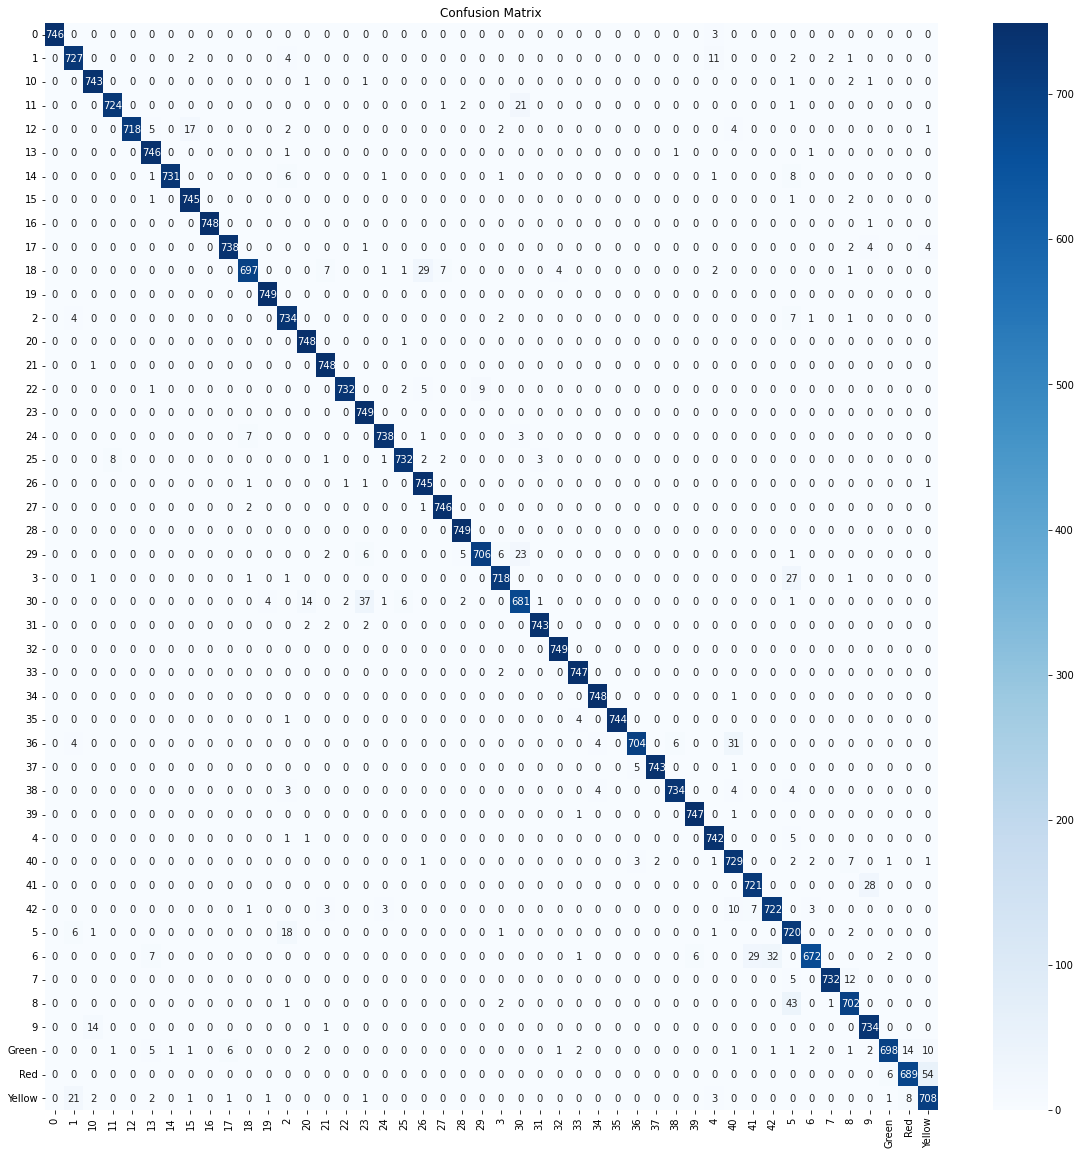

In [ ]:
# Loading the Best Model
model = load_model("SavedModels/"+model_name+".h5")

# Model Performance
y_test = test_set.labels
y_pred = model.predict(test_set).argmax(1)
report(y_test, y_pred)